In [1]:
import time 
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Flatten, Reshape, Dropout, Conv2D, MaxPooling2D
from keras.models import Model

2021-11-12 13:33:14.185494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-12 13:33:14.185612: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [20]:
pathToData = ''
num_classes = 0
pathToHistory = ''
def upd(mnist):
    global pathToData, num_classes, pathToHistory
    pathToData = 'mnist/' if mnist else 'emnist/'
    num_classes = 10 if mnist else 26

img_rows = img_cols = 28
show_k = True  # False True
svert = True
pred = True
mnist = not True

if svert:
        pathToHistory = 'svertM/'
elif mnist:
        pathToHistory = 'mnistM/'
else:
        pathToHistory = 'emnistM/'
        
name = 'easy'
upd(mnist)
refit = True
loss_func = 'poisson' #categorical_crossentropy poisson mse
epochs = 20
fn_model = pathToHistory + name +'/model.h5' #
#
suff = '.txt'
# Имена файлов, в которые сохраняется история обучения
fn_loss = pathToHistory + name + '/loss_' + suff
fn_acc = pathToHistory + name + '/acc_' + suff
fn_val_loss = pathToHistory + name + '/val_loss_' + suff
fn_val_acc = pathToHistory + name + '/val_acc_' + suff

In [21]:
def ch(i):
    if svert:
        if i < 10:
            return i
        else:
            return str(chr(ord('A')+i-10))
    elif mnist:
        return i
    elif not mnist:
        return str(chr(ord('A')+i))


def show_x(x, y, img_rows, img_cols, N):
    n = int(np.sqrt(N))
    plt.figure(figsize=(10,10))
    for i, j in enumerate(np.random.randint(len(x), size=n * n)):
        plt.subplot(n, n, i+1)
        # Убираем 3-е измерение
        plt.title(ch(y[j]))
        plt.imshow(x[j].reshape(img_rows, img_cols), cmap='gray')
        plt.axis('off')
    plt.show()

In [22]:
def one_plot(n, y_lb, loss_acc, val_loss_acc):
    plt.subplot(1, 2, n)
    if n == 1:
        lb, lb2 = 'loss', 'val_loss'
        yMin = 0
        yMax = 1.05 * max(max(loss_acc), max(val_loss_acc))
    else:
        lb, lb2 = 'acc', 'val_acc'
        yMin = min(min(loss_acc), min(val_loss_acc))
        yMax = 1.0
    plt.plot(loss_acc, color='r', label=lb, linestyle='--')
    plt.plot(val_loss_acc, color='g', label=lb2)
    plt.ylabel(y_lb)
    plt.xlabel('Эпоха')
    plt.ylim([0.95 * yMin, yMax])
    plt.legend()
# 
def loadBinData(pathToData, img_rows, img_cols):
    print('Загрузка данных из двоичных файлов...')
    with open(pathToData + 'imagesTrain.bin', 'rb') as read_binary:
        x_train = np.fromfile(read_binary, dtype=np.uint8)
    with open(pathToData + 'labelsTrain.bin', 'rb') as read_binary:
        y_train = np.fromfile(read_binary, dtype=np.uint8)
    with open(pathToData + 'imagesTest.bin', 'rb') as read_binary:
        x_test = np.fromfile(read_binary, dtype=np.uint8)
    with open(pathToData + 'labelsTest.bin', 'rb') as read_binary:
        y_test = np.fromfile(read_binary, dtype=np.uint8)
    # Преобразование целочисленных данных в float32 и нормализация; данные лежат в диапазоне [0.0, 1.0]
    if not mnist:
        y_train -= 1
        y_test -= 1
    x_train = np.array(x_train, dtype='float32') / 255
    x_test = np.array(x_test, dtype='float32') / 255
    x_train = x_train.reshape(-1, img_rows, img_cols)
    x_test = x_test.reshape(-1, img_rows, img_cols)
    # Преобразование в категориальное представление: метки - числа из диапазона [0, 9] в двоичный вектор размера num_classes
    # Так, в случае MNIST метка 5 (соответствует классу 6) будет преобразована в вектор [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
    # print(y_train[0]) # (MNIST) Напечатает: 5
    print('Преобразуем массивы меток в категориальное представление')
    y_train = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)
    # print(y_train[0]) # (MNIST) Напечатает: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
    return x_train, y_train, x_test, y_test

In [ ]:
def addZeros(num_classes, y_train, y_train1):
    tmp1 = np.zeros((y_train.shape[0], num_classes - y_train.shape[1]))
    tmp2 = np.zeros((y_train1.shape[0], num_classes - y_train1.shape[1]))
    y_train = np.concatenate([y_train, tmp1], axis = 1)
    y_train1 = np.concatenate([tmp2, y_train1], axis = 1)
    return y_train, y_train1


if svert:
    mnist = True
    upd(mnist)
    x_train, y_train, x_test, y_test = loadBinData(pathToData, img_rows, img_cols)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    mnist = False
    upd(mnist)
    x_train1, y_train1, x_test1, y_test1 = loadBinData(pathToData, img_rows, img_cols)
    print(x_train1.shape, y_train1.shape, x_test1.shape, y_test1.shape)
    num_classes = 36
    x_train = np.concatenate([x_train, x_train1], axis = 0)
    x_test = np.concatenate([x_test, x_test1], axis = 0)
    y_train, y_train1 = addZeros(num_classes, y_train, y_train1)
    y_train = np.concatenate([y_train, y_train1], axis = 0)
    y_test, y_test1 = addZeros(num_classes, y_test, y_test1)
    y_test = np.concatenate([y_test, y_test1], axis = 0)
else:
    x_train, y_train, x_test, y_test = loadBinData(pathToData, img_rows, img_cols)
    
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
if show_k:
    show_x(x_test, np.array([np.argmax(m) for m in y_test]), img_rows, img_cols, 25)
#
# Определяем форму входных данных
input_shape = (img_rows, img_cols, 1)

# 0.35-DR1024-0.2-DL52

if svert:
    x_train = np.expand_dims(x_train, axis=3)
    x_test = np.expand_dims(x_test, axis=3)

    print( x_train.shape )
    
    model = keras.Sequential()
    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(28, 28, 1)))
    model.add(MaxPooling2D((2, 2), strides=2))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPooling2D((2, 2), strides=2))
    model.add(Flatten())
    model.add(Dense(256,  activation='relu'))
    model.add(Dense(num_classes,  activation='softmax'))
    # model.add(Dense(64, activation='relu'))
    # model.add(Dense(num_classes,  activation='softmax'))
else:
    # x_shape = img_rows * img_cols

    # x_train = x_train.reshape(-1, x_shape)
    # x_test = x_test.reshape(-1, x_shape)

    # Создание модели нейронной сети
    model = keras.Sequential() 
    model.add(Flatten(input_shape=input_shape)) 
    # model.add(Reshape(target_shape=(img_rows * img_cols,), input_shape=input_shape)) 
    # model.add(keras.Input(x_shape)) 
    # model.add(Dense(784, activation='relu')) 
    # model.add(Dense(512, activation='relu')) 
    # model.add(Dense(128, activation='relu')) 
    model.add(Dense(32, activation='LeakyReLU')) 
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
print(model.summary())

Загрузка данных из двоичных файлов...
Преобразуем массивы меток в категориальное представление
(60000, 28, 28) (60000, 10) (10000, 28, 28) (10000, 10)
Загрузка данных из двоичных файлов...
Преобразуем массивы меток в категориальное представление
(124800, 28, 28) (124800, 26) (20800, 28, 28) (20800, 26)
(184800, 28, 28) (184800, 36) (30800, 28, 28) (30800, 36)


In [ ]:
def test_compile():
    from keras.models import load_model

    model = load_model(fn_model)
    # Оценка модели НС на тестовых данных
    score = model.evaluate(x_test, y_test)
    # Вывод потерь и точности
    print('Потери при тестировании:', round(score[0], 4))
    print('Точность при тестировании: {}{}'.format(score[1] * 100, '%'))
    # Прогноз
    y_pred = model.predict(x_test)
    # print(y_pred[0])
    # print(y_test[0])
    # [6.8e-6 1.5e-10 7.6e-6 1.5e-3 7.0e-9 6.2e-5 2.2e-11 9.9e-1 3.0e-7 5.9e-6]
    # [0.     0.      0.     0.     0.     0.     0.      1.     0.     0.]
    # Заносим в массив predicted_classes метки классов, предсказанных моделью НС
    predicted_classes = np.array([np.argmax(m) for m in y_pred])
    true_classes = np.array([np.argmax(m) for m in y_test])
    n_test = len(y_test)
    # Число верно классифицированных изображений
    true_classified = np.sum(predicted_classes == true_classes)
    # Число ошибочно классифицированных изображений
    false_classified = n_test - true_classified
    acc = 100.0 * true_classified / n_test
    print('Точность: {}{}'.format(acc, '%'))
    print('Неверно классифицированно:', false_classified)
    m, m_max = 0, 15
    lst_false = []
    print('  Индекс  | Прогноз | Правильный класс')
    for i in range(n_test):
        cls_pred = predicted_classes[i]  # Предсказанное моделью имя класса
        cls_true = true_classes[i]  # Истинное имя класса
        if cls_pred != cls_true:
            m += 1
            lst_false.append([i, cls_pred, cls_true])
            if (m < min(m_max, false_classified)): 
                print('  {:5d}   |    {}    |    {}'.format(i, ch(cls_pred), ch(cls_true)))
    print('...')
    
    corr_classes = [0 for i in range(num_classes)]
    wrng_classes = [0 for i in range(num_classes)]
    for i in range(n_test):
        tru = true_classes[i]
        got = predicted_classes[i]
        if tru == got:
            corr_classes[tru] += 1
        else:
            wrng_classes[tru] += 1
    
    print('Точность по классам:')
    print('Класс | Точность ')
    for i in range(0, num_classes):
        print('{:5} | {:10.5f}'.format(ch(i), corr_classes[i]/(corr_classes[i] + wrng_classes[i]+1)*100))
    
    plt.figure('Ошибки классификации')
    for k in range(15):
        plt.subplot(3, 5, k + 1)
        num = np.random.randint(len(lst_false))
        lst = lst_false[num]
        plt.imshow(x_test[lst[0]].reshape(img_rows, img_cols), cmap='gray')
        plt.title('{}/{}'.format(ch(lst[1]), ch(lst[2])))
        plt.axis('off')
    plt.show()

In [18]:
if refit:
    model.compile(optimizer='Adam', loss=loss_func, metrics=['accuracy'])
    # 
    # Обучение нейронной сети 
    start = time.time()
    history = model.fit(x_train, y_train, epochs=epochs, batch_size=64,
                        verbose=1, validation_data=(x_test, y_test))
    print('Время вычислений:', time.time() - start) 
    model.save(fn_model)
    print('Модель сохранена в файле', fn_model)
    # Запись истории обучения в текстовые файлы 
    history = history.history
    ##for itm in history.items(): print(itm) 

In [ ]:
    with open(fn_loss, 'w+') as output:
        for val in history['loss']: output.write(str(val) + '\n')
    with open(fn_acc, 'w+') as output:
        for val in history['accuracy']: output.write(str(val) + '\n')
    with open(fn_val_loss, 'w+') as output:
        for val in history['val_loss']: output.write(str(val) + '\n')
    with open(fn_val_acc, 'w+') as output:
        for val in history['val_accuracy']: output.write(str(val) + '\n')
    # Вывод графиков обучения 
    plt.figure(figsize=(9, 4))
    plt.subplots_adjust(wspace=0.5)
    one_plot(1, 'Потери', history['loss'], history['val_loss'])
    one_plot(2, 'Точность', history['accuracy'], history['val_accuracy'])
    plt.suptitle('Потери и точность')
    plt.show()
 

In [ ]:
if pred:
    test_compile()    

(30800, 28, 28, 1)
[[1.04459861e-04 1.36534641e-06 4.88432270e-05 2.06211389e-05
  4.24107675e-05 6.10079383e-07 3.73408060e-09 1.39505864e-04
  8.82145741e-06 9.99633193e-01 8.10669309e-09 5.00619997e-11
  1.08493559e-09 3.29149642e-12 5.67781822e-09 1.74468801e-10
  3.52910590e-08 2.26480808e-13 1.57020477e-14 1.01730354e-12
  2.32377399e-11 1.16762069e-14 6.52854073e-12 2.94171073e-13
  1.69772607e-09 9.64402336e-10 9.30019013e-08 3.82021664e-10
  9.45249018e-11 1.83498507e-14 2.58458966e-12 7.21869016e-13
  3.73672491e-12 5.67242650e-13 1.09217736e-13 3.44827444e-12]]


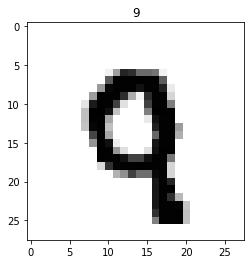

In [9]:
print(x_test.shape)
n = np.random.randint(1000)
x = np.expand_dims(x_test[n], axis=0)
res = model.predict(x)
print( res )
mx = np.argmax(res)

plt.title(ch(mx))
plt.imshow(np.reshape(x_test[n], (img_rows, img_cols)), cmap=plt.cm.binary)
plt.show()